# GLM on heart rate signal


This notebook employs Generalized Linear Models (GLMs) for heart rate modeling. The objective is to estimate and fit the parameters of a GLM using heart rate signals. Once the parameter fitting is completed, a simulated signal is generated based on these estimated parameters. The notebook explores two distinct probability distributions:
- Normal distribution
- Inverse Gaussian distribution

In [10]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt 
from numpy import random
from tqdm import tqdm
import scipy.stats as stats

import sys
sys.path.append('../')
import FractalAnalysis as fa

## Utils

In [3]:
def get_beats(subject, abnormal=False):
    """
    Get the heart rate data for a given subject

    Arguments:
    - subject:  ID of the subject to get the heart rate. Must be of the format
                "group" + "number" + "nn". Where group is n (healthy), c 
                (congestive heart failure) or a (atrial fibrillation) and the
                number is between 1 and 5.
    - abnormal: True to print the proportion of abnormal beats (i.e. noisy 
                data), False otherwise

    Returns:
    - A numpy array with the heart rate (interbeats) signal
    """

    with open('../Heart-rates-disease/' + subject + '.txt') as f:
        lines = f.readlines()

    beats = []
    
    count_abnormal = 0
    count = 0

    for line in lines:
        line = line.split()
        if line[1] != "N":
            count_abnormal += 1
        beats.append(float(line[0]))
        count += 1
    
    if abnormal:
        print("Abnormal beats: ", count_abnormal/count*100, "%")
    return np.asarray(beats)    

def get_matrix(sig, n):
    """
    From a given heart rate signal, build the matrix X of the observations and
    the matrix Y of the resulting value. These matrix are then used to get the
    best parameters value for the GLM

    Arguments:
    - sig: the heart rate signal on which the GLM will be fitted
    - n: the number of observations to predict one value

    Returns:
    - X: the matrix of observations
    - Y: the values to be estimated

    """
    Y = sig[n:]
    X = [sig[i:i+n] for i in range(len(sig)-n+1)]
    X = X[:len(X)-1]
    X = np.asarray(X)

    X_offset = np.hstack((np.ones((len(Y),1)), X))

    return X, X_offset, Y


def GLM_fit(X_offset, Y, family):
    """
    Fit the GLM on given data

    Arguments:
    - X_offset: the matrix of observations
    - Y: the vector of the final value
    - family: the distribution of the exponential family used for the GLM

    Returns:
    - The constant parameter beta_0
    - The vector of parameters beta
    - The scale of the distribution 
    """
    glm_model = sm.GLM(endog=Y, exog=X_offset, family=family)
    GLM_results = glm_model.fit(max_iter=100, tol=1e-6, tol_criterion='params')

    #print(GLM_results.aic)
    #igGLM_results = glm_inv_gaussian._fit_gradient()

    GLM_const = GLM_results.params[0]
    GLM_filt = GLM_results.params[1:] # stimulus filter

    GLM_scale = GLM_results.scale

    return GLM_const, GLM_filt, GLM_scale

def link_gaussian(theta):
    """
    Link function of the Gaussian distribution
    """
    return theta

def link_inv_gaussian(theta):
    """
    Link function of the Inverse Gaussian distribution
    """
    return np.sqrt(np.reciprocal(theta))

In [4]:
"""
- 1: Gaussian
- 2: Inverse gaussian
"""

gauss = sm.families.Gaussian()
inv_gauss = sm.families.InverseGaussian()
families = [gauss, inv_gauss]
links = [link_gaussian, link_inv_gaussian]

## GLM fit

In [13]:
exp_family = 0 # 0 for the Gaussian distribution, 1 for the inverse Gaussian distribution
subject = 'n1nn' # select the subject for the prediction
n = 1000 # number of observations for one prediction

sig = get_beats(subject)
sig = sig[:45000]
X, X_offset, Y = get_matrix(sig, n)

In [14]:
igGLM_const, igGLM_filt, GLM_scale = GLM_fit(X_offset, Y, families[exp_family])

theta = igGLM_const + X @ igGLM_filt
pred = links[exp_family](theta) # Predictions based on the observations

## Simulate heart rate

In [15]:
def plot_beats(b, title):
    f = plt.figure()
    f.set_figwidth(8)
    f.set_figheight(4)
    plt.title(title)
    plt.plot(b)
    plt.ylabel("RR interval(seconds)")
    plt.xlabel("beats")
    #plt.ylim(0.2,2)
    plt.savefig(title + ".pdf")
    plt.show()

100%|██████████| 100000/100000 [00:04<00:00, 22883.98it/s]


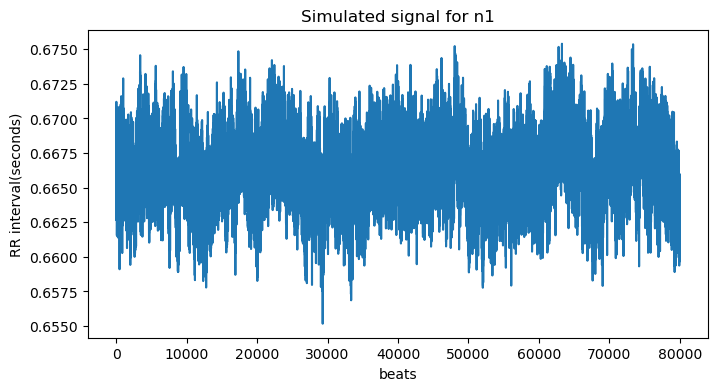

In [16]:
Num_points = 100000 # Number of points to be generated

generated_sig = np.zeros(Num_points)
X_i = X[0].tolist()

for i in tqdm(range(Num_points)):
    theta = igGLM_const + X_i @ igGLM_filt
    mu = links[exp_family](theta)
    generated_sig[i] = random.normal(loc=mu, scale=GLM_scale)
    #generated_sig[i] = stats.invgauss.rvs(mu=mu, scale=GLM_scale)
    X_i = X_i[1:]
    X_i.append(generated_sig[i])


plot_beats(generated_sig[20000:], "Simulated signal for n1")

### DFA

In [ ]:
x = np.linspace(np.log(5), np.log(1000), 30)
lag = np.exp(x).astype(int)
fa.DFA2(generated_sig, lag)

In [2]:
# DFA on all subjects
alphas = [1.0084754693730875, 1.089824190052185, 1.0246392270113434, 1.1256981207847045, 1.0852563676366787,
          0.6923753567104207, 0.6732725335737787, 0.7354899009340679, 0.7649896215382782, 0.7664317830541169, 
          1.150705266776526, 1.0664532584307225, 1.2465030519760192, 1.0942973771670477, 1.1415093294269292]

In [3]:
def bar_plot(measures, title):
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    width = 0.8

    fig, ax = plt.subplots()
    rects1 = ax.bar(x[:5], measures[:5], width, color="lightskyblue", ec="black")
    rects2 = ax.bar(x[5:10], measures[5:10], width, color="royalblue", ec="black")
    rects3 = ax.bar(x[10:], measures[10:], width, color="orchid", ec="black")

    ax.set_ylabel(r'$\alpha$')
    ax.set_xlabel('subject')
    ax.set_title(title)
    ax.set_xticks(np.add(x, (width / 2)))  # set the position of the x ticks
    ax.set_xticklabels(x)

    def autolabel(rects):
        # attach some text labels
        i = 0
        for rect in rects:
            height1 = rect.get_height()
            height2 = round(rect.get_height(), 2)
            ax.text(rect.get_x() + rect.get_width() / 2., 1.005 * height1, height2, ha='center', va='bottom')
            i += 1

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    ax.legend((rects1[0], rects2[0], rects3[0]), ('n', 'a', 'c'), loc='lower left')
    plt.savefig("GLM_gaussian.pdf")
    plt.show()

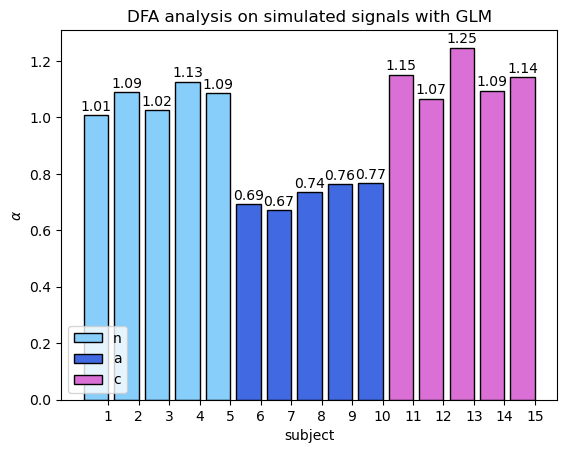

In [4]:
bar_plot(alphas, "DFA analysis on simulated signals with GLM")

## Prediction on dataset

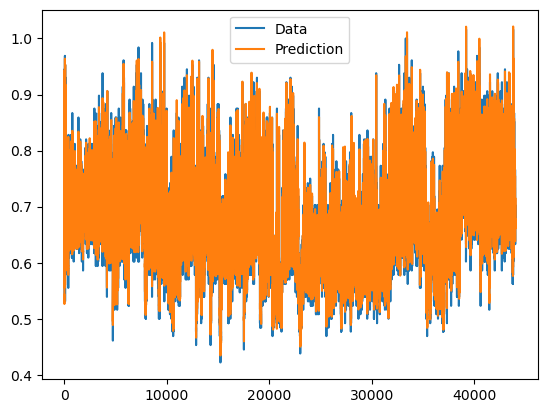

In [18]:
plt.plot(Y, label="Data")
plt.plot(pred, label="Prediction")

plt.legend()  
plt.show()

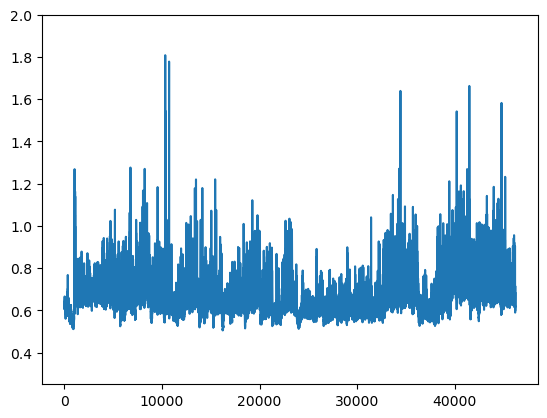

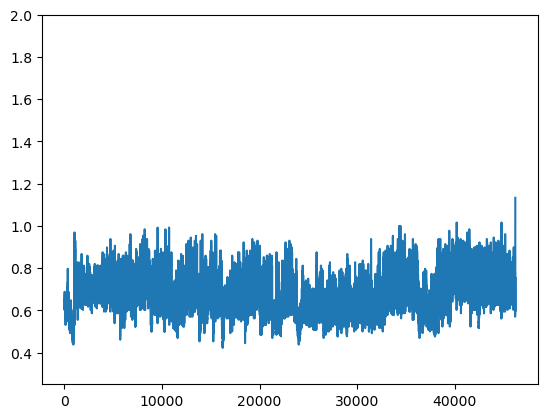

In [155]:
plt.plot(pred)
plt.ylim(0.25, 2)
plt.show()
plt.plot(Y)
plt.ylim(0.25, 2)
plt.show()

## Divide by time periods
The previous section fitted the GLM on the whole dataset. In this sections, the heart rate signal of a subject will be divided into sub-signals and several GLM fit will be performed.

In [19]:
def get_times(subject):
    """
    Returns the time of each beat of the heart of a given subject

    Arguments:
    - subject: ID of the subject to get the heart rate. Must be of the format
                "group" + "number" + "nn". Where group is n (healthy), c 
                (congestive heart failure) or a (atrial fibrillation) and the
                number is between 1 and 5.

    Returns:
    - A numpy array with the time at which each heart beat happens
    """
    
    with open('../Heart-rates-disease/' + subject + '.txt') as f:
        lines = f.readlines()

    beats = []
    
    count = 0

    for line in lines:
        line = line.split()
        beats.append(float(line[2]))
        count += 1

    beats = np.asarray(beats)  
    beats -= beats[0] # Want to start at 0
    return beats

    

### Fit the GLM

In [20]:
sig = get_times("n5nn")

delta = 280
t = delta

n = 1
exp_family = 0

params = []

while t < sig[-1]:
    mask = (sig>=t-delta) & (sig <= t)
    tmp_sig = sig[mask]

    taus = [tmp_sig[i+1]-tmp_sig[i] for i in range(len(tmp_sig)-1)]

    try:
        X, X_offset, Y = get_matrix(taus, n)
        GLM_const, GLM_filt, GLM_scale = GLM_fit(X_offset, Y, families[exp_family])
        params.append([GLM_const, GLM_filt, GLM_scale])

    except:
        params.append(params[-1])

    t += delta

### Simulate a heart rate signal

In [21]:
Num_points = 100
generated_sig = []
X_i = []

for i in range(n):
    X_i.append(sig[i+1]-sig[i])

final_time = sig[-1]
t = 0

num = 0 # Number of excecive values

while t < final_time:
    i = int(t // delta)
    if i >= len(params):
        break 
    t_params = params[i]
    theta = t_params[0] + X_i @ t_params[1]
    mu = links[exp_family](theta)
    tau = random.normal(loc=mu, scale=t_params[2])
    if tau < 0.2 or tau > 2:
        num += 1
        j = len(generated_sig)
        if j >= len(sig):
            j = len(sig) - 5
        tau = sig[j+1] - sig[j]
    generated_sig.append(tau)
    X_i = X_i[1:]
    X_i.append(tau)
    t += tau
    #print(t, tau)

print(num/len(generated_sig)*100) 

0.0111185234600845


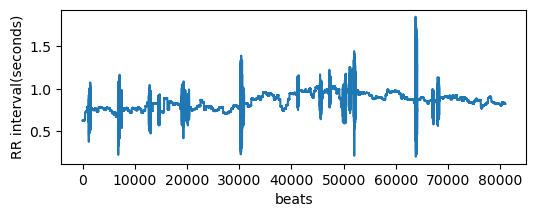

In [22]:
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(2)
plt.plot(generated_sig)
plt.ylabel("RR interval(seconds)")
plt.xlabel("beats")
#plt.ylim(0.4,1.4)
plt.show()